# *svoboda lab / tactile navigation*

## Setup evnironment

In [1]:
import os
import numpy as np
import pandas as pd
import scipy.io as sio
import json
import re
import requests
from scipy.stats import f_oneway
from scipy.interpolate import UnivariateSpline

## Setup plotting

In [2]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from colorsys import hsv_to_rgb, rgb_to_hsv
%matplotlib inline
import seaborn as sns
sns.set_context('paper')
sns.set_style('ticks')
from helper.plots import colormap

####Widgets

In [3]:
from IPython.html import widgets
from IPython.display import display
from IPython.html.widgets import interactive

:0: FutureWarning: IPython widgets are experimental and may change in the future.


## Load raw data

In [4]:
path = 'https://s3.amazonaws.com/neuro.datasets/svoboda.lab/tactile.coding/'

In [5]:
iSession = 1
session = '%02g' % iSession

#### Load info

In [6]:
r = requests.get(path + session + '/info.json').content
info = json.loads(r)
info['contributors'] = ', '.join(info['contributors'])
info = pd.DataFrame(info, index = [str(info['id'])])

#### Load params

In [7]:
covariates = pd.DataFrame.from_csv(path + session + '/params/covariates.csv')
covariates['timeStamp'] = range(len(covariates))
covariates.set_index(['timeStamp'], inplace=True)
covariates['timeStamp'] = range(len(covariates))
pattern = re.compile('OL_.*L')
indexL = covariates.trialType.str.match(pattern, as_indexer=True)
covariates.corPos.loc[indexL] = 30 - covariates.corPos.loc[indexL]
covariates['optoPos'] = np.convolve(covariates.laserPower, np.ones((100,))/2, mode='same')
covariates.optoPos = (covariates.optoPos.max()-covariates.optoPos)/covariates.optoPos.max()*30

/Users/sofroniewn/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


####Load spikes

In [8]:
times = pd.DataFrame.from_csv(path + session + '/spikes/times.csv')
waveforms = pd.DataFrame.from_csv(path + session + '/spikes/waveforms.csv')
properties = pd.DataFrame.from_csv(path + session + '/spikes/properties.csv')
times['spkAmp'] = waveforms['0.0']
waveforms['sourceId'] = times['sourceId']

## Create unit summary information

#### Unit firing rate information

In [9]:
units = properties

In [10]:
numSpikes = times.groupby(['sourceId'], sort=True).count().trialNum.values
units = units.join(pd.DataFrame({'numSpikes':numSpikes}))
units = units.join(-times[['sourceId','spkAmp']].groupby(['sourceId'], sort=True).mean())

In [11]:
meanWaveform = waveforms.groupby('sourceId').mean()
stdWaveform = waveforms.groupby('sourceId').std().mean(1)
rangeWaveform = meanWaveform.max(1) - meanWaveform.min(1)
waveformSNR = rangeWaveform.divide(stdWaveform)
units = units.join(pd.DataFrame({'waveformSNR':waveformSNR.values}))

In [12]:
def getFiringRate(sourceId):
    spkTimes = times[times.sourceId == sourceId]
    spkCount = spkTimes.groupby(['trialNum']).count().iloc[:,0]
    trialDuration = covariates.groupby(['trialNum']).count().iloc[:,0]
    spkCount = spkCount.divide(trialDuration)*500
    spkCount = spkCount.fillna(0)
    return spkCount

In [13]:
def getSpkAmpDrift(sourceId):
    spkAmp = times[times.sourceId == sourceId].groupby(['trialNum'])['spkAmp'].mean()
    early = spkAmp[spkAmp.index < spkAmp.index[0] + len(spkAmp)/3].mean()
    late = spkAmp[spkAmp.index > spkAmp.index[0] + 2*len(spkAmp)/3].mean()
    drift = (early - late)/spkAmp.mean()*100
    return drift

In [14]:
def getFiringDrift(sourceId):
    spkCount = getFiringRate(sourceId)
    early = spkCount[spkCount.index < spkCount.index[0] + len(spkCount)/3].mean()
    late = spkCount[spkCount.index > spkCount.index[0] + 2*len(spkCount)/3].mean()
    firingDrift = (early - late)/spkCount.mean()*100
    return firingDrift

In [15]:
units = units.join(pd.DataFrame({'firingDrift':[getFiringDrift(x) for x in units.sourceId]}))
units = units.join(pd.DataFrame({'spkAmpDrift':[getSpkAmpDrift(x) for x in units.sourceId]}))

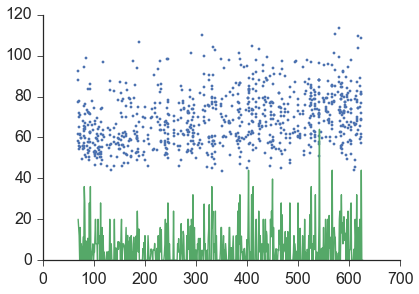

In [16]:
sourceId = 14
spkCount = getFiringRate(sourceId)
spkTimes = times[times.sourceId == sourceId]
plt.plot(spkTimes.trialNum,-spkTimes.spkAmp,'.');
plt.plot(spkCount.index.values,spkCount.values*20);
sns.despine()

#### Compute waveforms

In [17]:
def smoothfit(x, y, smooth=0, res=1000):
    spl = UnivariateSpline(x, y)
    spl.set_smoothing_factor(smooth)
    xs = np.linspace(np.min(x), np.max(x), res)
    return xs, spl(xs)

In [18]:
def getSpkWidth(sourceId):
    xs, ys = smoothfit(meanWaveform.columns.astype('float').values, meanWaveform.loc[sourceId].values, smooth=100)
    minLoc = ys.argmin()
    spkWidth = ys[minLoc:].argmax()
    spkWidth = xs[minLoc + spkWidth] - xs[minLoc]
    spkWidth = spkWidth*1000
    return spkWidth

In [19]:
units = units.join(pd.DataFrame({'spkWidth':[getSpkWidth(x) for x in units.sourceId]}))

In [20]:
def plotWaveform(sourceId):
    xs, ys = smoothfit(meanWaveform.columns.astype('float').values, meanWaveform.loc[sourceId].values, smooth=100)
    plt.plot(xs,ys);

In [21]:
def classifyCellType(SpikeWidth):
    if SpikeWidth < 350:
        label = 'FastSpiker'
    elif SpikeWidth < 450:
        label = 'IntermediateSpiker'
    else:
        label = 'RegularSpiker'
    return label

In [22]:
units = units.join(pd.DataFrame({'cellType':units.spkWidth.apply(classifyCellType)}))

#### Create ISI plot

In [23]:
def getSpikeISI(sourceId,threshFA):
    spkDiff = times[times.sourceId == sourceId].spkTime.diff()
    spkDiff[spkDiff<0] = np.NaN
    rateFA = float(sum(spkDiff<threshFA))/spkDiff.count()*100
    timesISI = np.linspace(0,.02,300)
    ISI = np.histogram(spkDiff,timesISI)[0]
    peakTimeISI = timesISI[ISI.argmax()]
    timesISI = timesISI[:-1]
    timesISI = np.concatenate((-np.fliplr([timesISI])[0],timesISI[1:]),axis = 1)
    ISI = np.concatenate((np.fliplr([ISI])[0],ISI[1:]),axis = 1)
    return timesISI, ISI, peakTimeISI, rateFA

In [24]:
threshFA = 0.0025

In [25]:
units = units.join(pd.DataFrame({'rateFA':[getSpikeISI(x,threshFA)[3] for x in units.sourceId]}))

In [26]:
units = units.join(pd.DataFrame({'peakTimeISI':[getSpikeISI(x,threshFA)[2] for x in units.sourceId]}))

In [27]:
ISI = pd.DataFrame([getSpikeISI(x,threshFA)[1] for x in units.sourceId])
ISI.columns = getSpikeISI(0,threshFA)[0]

## Process data

#### Create trial summary

In [28]:
trialData = covariates[['trialType','trialNum']].groupby(['trialNum'], sort=True).first()
trialData = trialData.join(covariates[['speed','trialNum','wallDistOL']].groupby(['trialNum'], sort=True).mean())
trialData.sort('wallDistOL', inplace = True, ascending = True)

#### Convert spike times inside trial to timeStamps of behavior data

In [29]:
trialStart = covariates[['timeStamp','trialNum']].groupby('trialNum').first()
times['timeStamp'] = trialStart.timeStamp[times.trialNum].values + (500*times.spkTime).round()+500
times['corPos'] = covariates.corPos.loc[times.timeStamp.values].values
times['optoPos'] = covariates.optoPos.loc[times.timeStamp.values].values

In [30]:
def getSpikeTimeseries(sourceId):
    data = times[(times['sourceId'] == sourceId) & (times['timeStamp'] < len(covariates))]
    data = data.groupby('timeStamp').count()
    timeSeries = np.zeros(len(covariates))
    timeSeries[data.index.values.astype('int')] = data.trialNum
    timeSeries[covariates['itiPeriod'].values.astype('bool')] = np.NaN
    return timeSeries

In [31]:
sourcesList = units.index.values
sources = widgets.Select(options = [str(x) for x in sourcesList])
wS = interactive(lambda source:source, source=sources)

#### Define speed threshold

In [32]:
speedThresh = 3

## Make Raster

#### Make function which creates raster and overlay of covariate when given covariate name, sourceID, and list of trials

In [33]:
def getRaster(sourceId, trials, name):
    data = covariates[name]
    ephysData = times[times['sourceId'] == sourceId]
    
    lenTrial = 2001
    dataMat = np.zeros((len(trials),lenTrial))
    ind = 0
    spkTrial = []
    spkTime = []
    spkCol = []
    for iTrial in trials.index:
        tmp = data[(covariates['trialNum'] == iTrial) & (covariates['itiPeriod'] == 0)]
        if len(tmp) >= lenTrial:
            dataMat[ind,:] = tmp[:lenTrial]
        else:
            dataMat[ind,:len(tmp)] = tmp
            dataMat[ind,len(tmp):] = tmp[-1]
        tmp = ephysData[ephysData['trialNum'] == iTrial]
        spkTrial.extend(np.tile(ind,len(tmp.spkTime)))
        spkTime.extend(tmp.spkTime*500)
        spkCol.extend(tmp[name])
        
        ind = ind + 1
    return dataMat, spkTime, spkTrial, spkCol

In [34]:
def plotRaster(mat, time, trial, col, pal):
    #plt.imshow(mat, interpolation='none', aspect=5.0);
    plt.scatter(time, trial, 25, linewidth=0, c=col, cmap=pal, vmin=0, vmax=30);
    plt.xlim([0, 2000])
    sns.despine();
    plt.axis('off');
    plt.ylim([0, max(trial)])
    plt.gca().invert_yaxis();

Select open loop contra wall trials where mouse was running

In [35]:
display(wS)

In [36]:
u = int(wS.kwargs['source'])
pattern = re.compile('OL_.*R|OL_out')
indexOL = trialData.trialType.str.match(pattern, as_indexer=True)
indexRun = trialData.speed > speedThresh
trials = trialData[indexOL & indexRun]
trials = trials.sort('wallDistOL', ascending=False)
mat, time, trial, col = getRaster(u, trials, 'corPos')

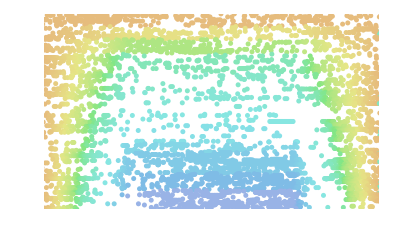

In [37]:
fig = plt.figure(figsize=(6,3.5))
plotRaster(mat, time, trial, col, colormap(0))

In [38]:
if info.ipsiAnm.values[0]:
    pattern = re.compile('OL_.*L|OL_out')
    indexOL = trialData.trialType.str.match(pattern, as_indexer=True)
    indexRun = trialData.speed > speedThresh
    trials = trialData[indexOL & indexRun]
    trials = trials.sort('wallDistOL', ascending=False)
    mat, time, trial, col = getRaster(u, trials, 'corPos')
    fig = plt.figure(figsize=(6,3.5))
    plotRaster(mat, time, trial, col, colormap(0))

## Tuning curve analysis

Tuning curve contains x values, mean, std, count of points, and ANOVA p value

In [39]:
def getTuning(df,T,X,Y,sourceId):
    df = df.groupby([T,X]).mean()
    df = df.reset_index().set_index(T)
    g = [df[df[X] == x][Y].values for x in df[X].unique()]
    f, p = f_oneway(*g)
    s = df.groupby([X])
    d = {'meanRate':s.mean()[Y].values,'stdRate':s.std()[Y].values,'numTrials':s.count().values[:,0]}
    tuning = pd.DataFrame(d).T
    tuning.columns = s.mean().index.values
    tuning['sourceId'] = sourceId
    tuning.reset_index(level=0, inplace=True)
    tuning.set_index('sourceId', inplace=True)
    tuning.rename(columns={'index':'label'}, inplace=True)
    tuning.index.name = None
    return tuning, p    

In [40]:
def getTuningEphys(sourceId,keepInd,name,scale):
    covariates['spikes'] = getSpikeTimeseries(sourceId)*500
    tmp = covariates[keepInd]
    tmp = tmp[~tmp['itiPeriod'].values.astype(bool)]
    tmp['bin'] = (tmp[name]/scale).round()*scale
    df = tmp[['trialNum','bin','spikes']]    
    tuning, p = getTuning(df,'trialNum','bin','spikes',sourceId)
    return tuning, p

####Compute tuning curve

Select open loop contra wall trials where mouse was running

In [41]:
pattern = re.compile('OL_.*R|OL_out')
indexOL = trialData.trialType.str.match(pattern, as_indexer=True)
indexRun = trialData.speed > speedThresh
trials = trialData[indexOL & indexRun]
keepInd = [x in trials.index for x in covariates.trialNum.values]
tuning = [getTuningEphys(x,keepInd,'corPos',3) for x in units.sourceId]
units['pVal'] = [x[1] for x in tuning]
tuning = pd.concat([x[0] for x in tuning])

####Compute ipsilateral tuning curve

Select open loop ipsi wall trials where mouse was running

In [42]:
if info.ipsiAnm.values[0]:
    pattern = re.compile('OL_.*L|OL_out')
    indexOL = trialData.trialType.str.match(pattern, as_indexer=True)
    indexRun = trialData.speed > speedThresh
    trials = trialData[indexOL & indexRun]
    keepInd = [x in trials.index for x in covariates.trialNum.values]
    tuningIpsi = [getTuningEphys(x,keepInd,'corPos',3) for x in units.sourceId]
    units['pValIpsi'] = [x[1] for x in tuningIpsi]
    tuningIpsi = pd.concat([x[0] for x in tuningIpsi])

#### Compute closed loop tuning curve

Select closed loop time points when mouse was running

In [43]:
if info.clAnm.values[0]:
    pattern = re.compile('CL_*')
    indexCL = trialData.trialType.str.match(pattern, as_indexer=True)
    indexRun = trialData.speed > speedThresh
    trials = trialData[indexCL & indexRun]
    keepInd = [x in trials.index for x in covariates.trialNum.values]
    tuningCL = [getTuningEphys(x,keepInd,'corPos',3) for x in units.sourceId]
    units['pValClosed'] = [x[1] for x in tuningCL]
    tuningCL = pd.concat([x[0] for x in tuningCL])

#### Compute running speed tuning curves

Select trials when wall was out of reach

In [44]:
pattern = re.compile('OL_.*R|OL_out')
indexOL = trialData.trialType.str.match(pattern, as_indexer=True)
indexFar = trialData.wallDistOL  > 20
trials = trialData[indexOL & indexFar]
keepInd = [x in trials.index for x in covariates.trialNum.values]
tuningSpeed = [getTuningEphys(x,keepInd,'speed',5) for x in units.sourceId]
units['pValSpeed'] = [x[1] for x in tuningSpeed]
tuningSpeed = pd.concat([x[0] for x in tuningSpeed])

##Compute wall direction curve

In [45]:
def getData(sourceId, trials, name):
    if name == 'spikes':
        covariates['spikes'] = getSpikeTimeseries(sourceId)
    data = covariates[name]
    lenTrial = 2001
    dataMat = np.zeros((len(trials),lenTrial))
    ind = 0
    for iTrial in trials.index:
        tmp = data[(covariates['trialNum'] == iTrial) & (covariates['itiPeriod'] == 0)]
        if name == 'spikes':
            tmp = np.convolve(tmp,np.ones(50)/50,mode = 'same')
        if len(tmp) >= lenTrial:
            dataMat[ind,:] = tmp[:lenTrial]
        else:
            dataMat[ind,:len(tmp)] = tmp
            dataMat[ind,len(tmp):] = tmp[-1]
        ind = ind + 1
    return dataMat

In [46]:
def getProfile(sourceId,trials,stimMat):
    dataMat = getData(sourceId,trials,'spikes')
    profiles = np.full([len(stimMat), 1000],np.nan)
    for iTrial in range(len(stimMat)):
        crossings = np.where(stimMat[iTrial]<=16)[0]
        if len(crossings)>0:
            profiles[iTrial,:500] = dataMat[iTrial][crossings[0]-150:crossings[0]+350]
            profiles[iTrial,500:] = dataMat[iTrial][crossings[-1]-350:crossings[-1]+150]
    meanProfile = np.nanmean(profiles,axis = 0)*500
    timeProfile = np.linspace(0,1.998,1000)
    return meanProfile, timeProfile    

Select open loop contra wall trials where mouse was running and wall was close

In [47]:
pattern = re.compile('OL_.*R|OL_out')
indexOL = trialData.trialType.str.match(pattern, as_indexer=True)
indexRun = trialData.speed > speedThresh 
indexWall = trialData.wallDistOL  <= 16
trials = trialData[indexOL & indexRun & indexWall]
stimMat = getData(0,trials,'corPos')

In [48]:
profile = pd.DataFrame([getProfile(x,trials,stimMat)[0] for x in units.sourceId])
timeProfile = getProfile(0,trials,stimMat)[1]
profile.columns = timeProfile